## best score of 0.13 with random forest regressor

In [185]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor

## here the train and test data are merged as some categorical columns in train contain only 3 classes while test contain 4 classes

In [186]:
pd.set_option("display.max_rows", 76)
pd.set_option("display.max_columns", 100)

In [187]:
train = pd.read_csv('dataset/housing/train.csv')
test = pd.read_csv('dataset/housing/test.csv')
df = pd.concat([train, test], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [188]:
df.drop(['Alley'], axis=1, inplace=True)
df.isnull().sum()

1stFlrSF        0
2ndFlrSF        0
3SsnPorch       0
BedroomAbvGr    0
BldgType        0
               ..
Utilities       2
WoodDeckSF      0
YearBuilt       0
YearRemodAdd    0
YrSold          0
Length: 80, dtype: int64

## sale price is target and is not there in test.csv ..so dont remove it.

In [189]:
df.drop(['Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC'], axis=1, inplace=True)

### lets reomove the features which are highly correlated as they convey the same data

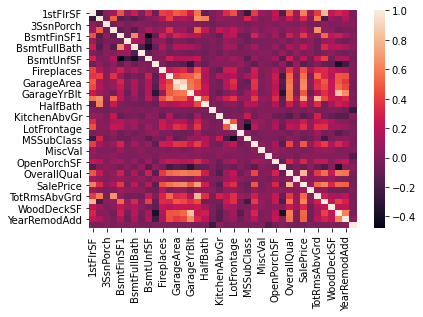

In [29]:
sns.heatmap(df.corr())

### lets focus on features which have missing values

In [191]:
def highcorr(cols):
    high = {}
    for column in cols.index:
        for row in cols.index:
            if cols[column][row]>0.7:
                high.update({f'{column}' : row})

    return high

highcorr(df.corr())

{'1stFlrSF': 'TotalBsmtSF',
 '2ndFlrSF': '2ndFlrSF',
 '3SsnPorch': '3SsnPorch',
 'BedroomAbvGr': 'BedroomAbvGr',
 'BsmtFinSF1': 'BsmtFinSF1',
 'BsmtFinSF2': 'BsmtFinSF2',
 'BsmtFullBath': 'BsmtFullBath',
 'BsmtHalfBath': 'BsmtHalfBath',
 'BsmtUnfSF': 'BsmtUnfSF',
 'EnclosedPorch': 'EnclosedPorch',
 'Fireplaces': 'Fireplaces',
 'FullBath': 'FullBath',
 'GarageArea': 'GarageCars',
 'GarageCars': 'GarageCars',
 'GarageYrBlt': 'YearBuilt',
 'GrLivArea': 'TotRmsAbvGrd',
 'HalfBath': 'HalfBath',
 'Id': 'Id',
 'KitchenAbvGr': 'KitchenAbvGr',
 'LotArea': 'LotArea',
 'LotFrontage': 'LotFrontage',
 'LowQualFinSF': 'LowQualFinSF',
 'MSSubClass': 'MSSubClass',
 'MasVnrArea': 'MasVnrArea',
 'MiscVal': 'MiscVal',
 'MoSold': 'MoSold',
 'OpenPorchSF': 'OpenPorchSF',
 'OverallCond': 'OverallCond',
 'OverallQual': 'SalePrice',
 'PoolArea': 'PoolArea',
 'SalePrice': 'SalePrice',
 'ScreenPorch': 'ScreenPorch',
 'TotRmsAbvGrd': 'TotRmsAbvGrd',
 'TotalBsmtSF': 'TotalBsmtSF',
 'WoodDeckSF': 'WoodDeckSF',
 'Y

## remove one of the attributes having high correlation ...choose one with less na values

In [192]:
df.drop(['TotalBsmtSF', 'GarageYrBlt', 'GrLivArea', 'Id'],axis=1, inplace=True)

## remove the ones with less correlation with sale price

In [193]:
df.corr()['SalePrice']

1stFlrSF         0.605852
2ndFlrSF         0.319334
3SsnPorch        0.044584
BedroomAbvGr     0.168213
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
BsmtUnfSF        0.214479
EnclosedPorch   -0.128578
Fireplaces       0.466929
FullBath         0.560664
GarageArea       0.623431
GarageCars       0.640409
HalfBath         0.284108
KitchenAbvGr    -0.135907
LotArea          0.263843
LotFrontage      0.351799
LowQualFinSF    -0.025606
MSSubClass      -0.084284
MasVnrArea       0.477493
MiscVal         -0.021190
MoSold           0.046432
OpenPorchSF      0.315856
OverallCond     -0.077856
OverallQual      0.790982
PoolArea         0.092404
SalePrice        1.000000
ScreenPorch      0.111447
TotRmsAbvGrd     0.533723
WoodDeckSF       0.324413
YearBuilt        0.522897
YearRemodAdd     0.507101
YrSold          -0.028923
Name: SalePrice, dtype: float64

In [194]:
df.drop(['BsmtHalfBath', 'BsmtFinSF2', 'LowQualFinSF', 'MiscVal', 'YrSold'], axis=1, inplace=True)

In [195]:
objs = [ i for i in df.select_dtypes(include=['object']).columns ]
nums = [ i for i in df.describe().columns ] # select dtype float and int not working properly

In [196]:
nums.pop(nums.index('SalePrice'))

'SalePrice'

In [197]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='mean'))
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("ohe", OneHotEncoder()),
])

In [198]:
full_pipeline = ColumnTransformer(transformers=[
    ("num", num_pipeline, nums),
    ("cats", cat_pipeline, objs),
], remainder='passthrough')


In [199]:
# data = df[df['SalePrice'] is not np.nan]
# above doent work because nan isnt equal to anything including nan
y = df['SalePrice'].dropna()

In [200]:
y

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

In [201]:
X1 = df.loc[df['SalePrice'].notnull()]

In [220]:
X = X1.drop('SalePrice', axis=1)

In [221]:
X.shape

(1460, 66)

In [211]:
X = full_pipeline.fit_transform(X)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

In [103]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=7)
rnd_reg = RandomForestRegressor(random_state=7)
ada_reg = AdaBoostRegressor(random_state=7, )
grad_reg = GradientBoostingRegressor(random_state=7, )

In [94]:
params = [{'max_depth': [1,2,3,4,5,6,7], 'criterion': ["mse", "friedman_mse", "mae"]}]

In [95]:
grid = GridSearchCV(tree_clf, param_grid=params, cv=5)
grid.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=10, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=7, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ['mse', 'friedman_mse', 'mae'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=F

In [96]:
grid.best_params_

{'criterion': 'mse', 'max_depth': 6}

In [128]:
def best_grid(estimator, params):
    grid = GridSearchCV(estimator=estimator, param_grid=params, cv=5)
    grid.fit(X, y)
    print(grid.best_params_)
    print(grid.best_score_)

In [132]:
estmlist = [tree_reg, rnd_reg, grad_reg, ada_reg]

params = [
          {'max_depth': [1,2,3,4,5,6,7], 'criterion': ["mse", "friedman_mse", "mae"]},
          {'n_estimators': [125, 150, 175, 200]},
          {'learning_rate': [0.01,0.001], 'n_estimators':[175, 185, 200, 225]},
          {'base_estimator': [rnd_reg, tree_reg], 'n_estimators':[50, 100, 125, 150], 'learning_rate': [0.01, 0.001]}
        ]

In [133]:
for i,j in zip(estmlist, params):
    best_grid(i,j)

{'n_estimators': 175}
0.848447837722689
{'learning_rate': 0.01, 'n_estimators': 225}
0.8052101323416435


In [247]:
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=7)
rnd_reg = RandomForestRegressor(n_estimators=175, random_state=7)
grad_reg = GradientBoostingRegressor(n_estimators=225, random_state=7)
# ada_reg = AdaBoostRegressor(base_estimator=rnd_reg, n_estimators=50, random_state=7)

In [248]:
rnd_reg

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=175, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [213]:
vot_reg = VotingRegressor(estimators=[
    ('tr', tree_reg),
    ('rn', rnd_reg),
    ('grad', grad_reg),
    # ('ada', ada_reg) # taking too long
])

In [140]:
cross_val_score(vot_reg, X, y, cv=5)

array([0.86971937, 0.83665245, 0.86229734, 0.8280279 , 0.85486314])

In [214]:
X.shape

(1460, 262)

In [215]:
vot_reg.fit(X, y)

VotingRegressor(estimators=[('tr',
                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse', max_depth=6,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=7,
                                                   splitter='best')),
                            ('rn',
                             RandomForestRegressor(bo

In [222]:
dftest = df.loc[df['SalePrice'].isnull()]
# ytest = dftest['SalePrice']
Xtest = dftest.drop('SalePrice', axis=1)

In [223]:
Xtest.shape

(1459, 66)

## after perprocessing no of feature in X and xtest were different hence the whole data is preprocessed at same time 
## this is possible as some categories were absent in train or test data

In [224]:
Xfull = pd.concat([X,Xtest], axis=0)

In [225]:
Xfull.shape

(2919, 66)

In [226]:
Xfull = full_pipeline.fit_transform(Xfull)

In [227]:
Xfull.shape

(2919, 262)

In [230]:
Xtest1 = Xfull[1460:]

In [231]:
Xtest1.shape

(1459, 262)

In [237]:
Xtrain1 = Xfull[:1460]

In [218]:
Xtest = full_pipeline.fit_transform(Xtest)

In [219]:
Xtest.shape

(1459, 246)

In [233]:
ytest_pred = vot_reg.predict(Xtest1)

In [234]:
ytest_pred.shape

(1459,)

In [235]:
sample = pd.read_csv('dataset/housing/sample_submission.csv')
sample['SalePrice'] = ytest_pred
sample.to_csv('dataset/housing/1stsub.csv', index=False)

In [249]:
rnd_reg.fit(Xtrain1, y)
ypred_rn = rnd_reg.predict(Xtest1)
sample['SalePrice'] = ypred_rn
sample.to_csv('dataset/housing/rnregsubtuned.csv', index=False)

In [239]:
grad_reg.fit(Xtrain1, y)
ypred_grad = grad_reg.predict(Xtest1)
sample['SalePrice'] = ypred_grad
sample.to_csv('dataset/housing/gradregsub.csv', index=False)

In [250]:
tree_reg.fit(Xtrain1, y)
ypred_tree = tree_reg.predict(Xtest1)
sample['SalePrice'] = ypred_tree
sample.to_csv('dataset/housing/treeregsub.csv', index=False)

## below codes dont work....need improvement

In [151]:
dftrail = train

In [156]:
dftrail['Id'][:1314].shape, y_train.shape

((1314,), (1314,))

In [161]:
def plot_training(row, columns, regs, X_train, X_test, y_train, y_test):
    global dftrail
    x = dftrail['Id'][:1314]
    plt.figure(figsize=(11,8)),
    y_pred = []
    for reg in regs:
        reg.fit(X_train, y_train)
        y_pred.append(reg.predict(X_train))
    for i in range(len(regs)):
        plt.subplot(row,columns,i+1)
        # plt.scatter(X, y, 'b.')
        plt.scatter(x, y_train, 'g.') # X_train in 66 dimensional while y is 1 dimensional ...hence use id
        plt.plot(x, y_pred[i], 'r-') # divided into training and splitting

In [162]:
plot_training(2, 2, [tree_reg, rnd_reg, grad_reg], X_train, X_test, y_train, y_test)

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''